In [31]:
from PIL import Image
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
os.chdir("C:\\Users\\jason\\Desktop\\SSC2019CaseStudy")
import warnings
warnings.filterwarnings('ignore')

# Explore the cell imges
## load train dataset

In [66]:
df=pd.read_csv('train_label.csv',index_col='image_name')
df.head()

,count,blur,stain
image_name,,,
A01_C1_F1_s01_w2.TIF,1,1,2
A01_C1_F1_s02_w1.TIF,1,1,1
A01_C1_F1_s02_w2.TIF,1,1,2
A01_C1_F1_s03_w2.TIF,1,1,2
A01_C1_F1_s04_w2.TIF,1,1,2


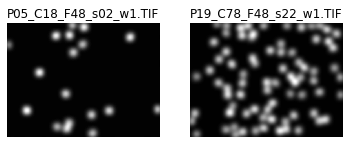

In [24]:
n=2
for i in range(n):
    plt.subplot(1,n,i+1)
    img_name=rd.choice(df.index)
    im = Image.open('train/'+img_name)
    im=np.array(im)
    plt.imshow(im,cmap='gray')
    plt.title(img_name)
    plt.axis('off')

## compare img with different cell count

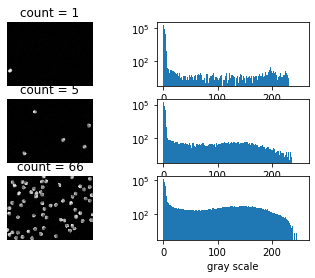

In [65]:
img_name=['A01_C1_F1_s13_w1.TIF',
   'A02_C5_F1_s09_w1.TIF',
    'A16_C66_F1_s04_w1.TIF']
n=len(img_name)
for i in range(n):
    im = Image.open('train/'+img_name[i])
    im=np.array(im)
    plt.subplot(n,2,2*i+1)
    plt.imshow(im,cmap='gray')
    plt.title('count = '+ str(df.loc[img_name[i],'count']))
    plt.axis('off')
    plt.subplot(n,2,2*i+2)
    plt.hist(im.reshape(-1,1),bins=range(0,256,1))
    plt.yscale('log')
    plt.xlabel('gray scale')

## compare img with different level of F and w

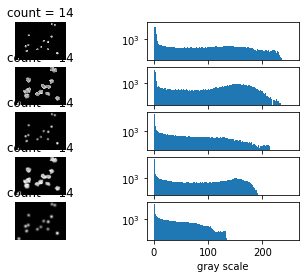

In [67]:
img_name = df.filter(like='C14',axis=0).filter(like='s11',axis=0).index
n=len(img_name)
for i in range(n):
    im = Image.open('train/'+img_name[i])
    im=np.array(im)
    plt.subplot(n,2,2*i+1)
    plt.imshow(im,cmap='gray')
    plt.title('count = '+ str(df.loc[img_name[i],'count']))
    plt.axis('off')
    plt.subplot(n,2,2*i+2)
    plt.hist(im.reshape(-1,1),bins=range(0,256,1))
    plt.yscale('log')
    plt.xlabel('gray scale')

In [65]:
img_name

Index(['A04_C14_F1_s11_w1.TIF'], dtype='object', name='image_name')

# Linear regression with grey scale

In [2]:
from Regression import PoolRegressor
import utils
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

## For F1 w1 images 

In [21]:
F = 'F1'
w = 'w1'
X, df = utils.read_imgset(csv_path='train_label.csv',train=True, F=F, w=w, hist = True)
X, df = shuffle(X, df, random_state=0)

## cross validation

In [54]:
kf = KFold(n_splits=10)
fit=PoolRegressor(pool= False)
mse_train=[]
mse_test=[]
df['pred']=0
for train, test in kf.split(X):
    ytrain= df['count'][train]
    fit.train(X[train,], df['count'][train])
    ypred=fit.predict(X[train,])
    mse_train.append( mean_squared_error(y_pred=ypred,y_true=df['count'][train]))
    ypred=fit.predict(X[test,])
    df['pred'][test]=ypred
    mse_test.append(mean_squared_error(y_pred=ypred,y_true=df['count'][test]))
print('train mse = ',np.mean(mse_train),'+/-', np.std(mse_train))
print('test mse = ',np.mean(mse_test),'+/-', np.std(mse_test))

train mse =  0.09604340485504105 +/- 0.006622262312150045
test mse =  2.389303273614496 +/- 0.33634267102092574


train mse is way smaller than test mse, **overfitting alert**!

Text(0, 0.5, 'residuals')

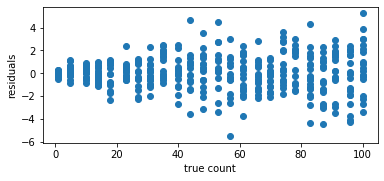

In [55]:
residual = np.array(df['count']) - np.array(df['pred'])
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(np.array(df['count']),residual)
plt.xlabel('true count')
plt.ylabel('residuals')

The error increase when more cells in the image

## pooling

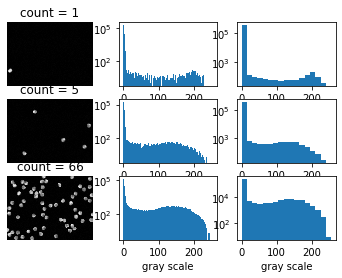

In [56]:
img_name=['A01_C1_F1_s13_w1.TIF',
   'A02_C5_F1_s09_w1.TIF',
    'A16_C66_F1_s04_w1.TIF']
n=len(img_name)
for i in range(n):
    im = Image.open('train/'+img_name[i])
    im=np.array(im)
    plt.subplot(n,3,3*i+1)
    plt.imshow(im,cmap='gray')
    plt.title('count = '+ str(df.loc[img_name[i],'count']))
    plt.axis('off')
    plt.subplot(n,3,3*i+2)
    plt.hist(im.reshape(-1,1),bins=range(0,256,1))
    plt.yscale('log')
    plt.xlabel('gray scale')
    plt.subplot(n,3,3*i+3)
    plt.hist(im.reshape(-1,1),bins=range(0,256,15))
    plt.yscale('log')
    plt.xlabel('gray scale')

In [57]:
fit=PoolRegressor(window=15,step=15,pool= True)
mse_train=[]
mse_test=[]
df['pooling_pred']=0
for train, test in kf.split(X):
    ytrain= df['count'][train]
    fit.train(X[train,], df['count'][train])
    ypred=fit.predict(X[train,])
    mse_train.append( mean_squared_error(y_pred=ypred,y_true=df['count'][train]))
    ypred=fit.predict(X[test,])
    df['pooling_pred'][test]=ypred
    mse_test.append(mean_squared_error(y_pred=ypred,y_true=df['count'][test]))
print('train mse = ',np.mean(mse_train),'+/-', np.std(mse_train))
print('test mse = ',np.mean(mse_test),'+/-', np.std(mse_test))

train mse =  0.5545320752842191 +/- 0.01830920026615093
test mse =  0.6205896336762233 +/- 0.17798416968612663


Overfitting issue is solved by pooling (setting wider bins)

Text(0, 0.5, 'residuals')

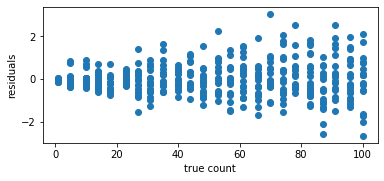

In [58]:
residual = np.array(df['count']) - np.array(df['pooling_pred'])
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(np.array(df['count']),residual)
plt.xlabel('true count')
plt.ylabel('residuals')

**heteroscedasticity** the residuals still get larger as the prediction moves from small to large

How to Fix
+ The most frequently successful solution is to transform a variable.
+ Often heteroscedasticity indicates that a variable is missing.


### log trasforamtion (failed)

In [59]:
X_log=np.log(X+1)
fit=PoolRegressor(window=15,step=15,pool= True)
mse_train=[]
mse_test=[]
df['log_pred']=0
for train, test in kf.split(X):
    ytrain= df['count'][train]
    fit.train(X_log[train,], df['count'][train])
    ypred=fit.predict(X_log[train,])
    mse_train.append( mean_squared_error(y_pred=ypred,y_true=df['count'][train]))
    ypred=fit.predict(X_log[test,])
    df['log_pred'][test]=ypred
    mse_test.append(mean_squared_error(y_pred=ypred,y_true=df['count'][test]))
print('train mse = ',np.mean(mse_train),'+/-', np.std(mse_train))
print('test mse = ',np.mean(mse_test),'+/-', np.std(mse_test))

train mse =  137.2764500289679 +/- 6.5020079871442205
test mse =  196.17602353002354 +/- 132.57460287167424


Text(0, 0.5, 'residuals')

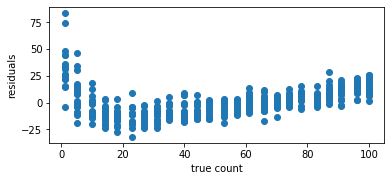

In [60]:
residual = np.array(df['count']) - np.array(df['log_pred'])
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(np.array(df['count']),residual)
plt.xlabel('true count')
plt.ylabel('residuals')

Patterns like this indicate that a variable needs to be transformed you probably need to create a **nonlinear** model